Application 

In [11]:
#Choose one picture and execute notebook

#from drive
img_path= "/content/drive/MyDrive/work/Oliv/images_clean/Hygrocybe/34930.jpg"

#or from internet
img_path= "https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Cortinarius_purpurascens_65102.jpg/1024px-Cortinarius_purpurascens_65102.jpg"

#img_path="https://static.aujardin.info/cache/th/champignons/lactarius-sanguifluus-600x450.jpg"

#img_path = "https://www.pharmanatur.com/Mycologie/Gymnopus%20hariolorum%205.jpg"

#img_path = "https://magazine.pretapousser.fr/wp-content/uploads/2016/09/000001-222.jpg"
#un genre qu'il ne connait pas :
#img_path = "https://static.aujardin.info/cache/th/champignons/psathyrella-corrugis-600x450.jpg"

img_path= "/content/drive/MyDrive/work/Oliv/images_clean/Amanita/7162.jpg"


In [2]:
import os 
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage import io
from numpy import dstack
from google.colab import drive
import joblib #to load and save sklearn models
import matplotlib.pyplot as plt
import seaborn as sns

GDRIVE_MOUNT_POINT = '/content/drive'
WORK_DIR = "/content/drive/MyDrive/work/Oliv"
MODEL_DIR = "/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/"

if not os.path.isdir(GDRIVE_MOUNT_POINT):
  drive.mount(GDRIVE_MOUNT_POINT)


Mounted at /content/drive


In [5]:
list_genus=['Agaricus',
 'Amanita',
 'Armillaria',
 'Cortinarius',
 'Entoloma',
 'Gymnopus',
 'Hygrocybe',
 'Lactarius',
 'Marasmius',
 'Russula']

In [3]:
#Models need to be loaded

def get_img_array(img_path, size):
    # `img` is a PIL image of size XxX
    if "https://" in img_path:
        img= io.imread(img_path)
        io.imsave(WORK_DIR + "/images_test/test.jpg"  , img)
        img_path = WORK_DIR + "/images_test/test.jpg"

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    #img = tf.keras.preprocessing.image.load_img(img, target_size=size)
    
    # `array` is a float32 Numpy array of shape (X, X, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, X, X, 3)
    array = np.expand_dims(array, axis=0)
    return array

def load_all_models():
    all_models = {}
    filenames = []
    for root, dirs, files in os.walk(MODEL_DIR): 
        if ("0002/train/0001" in root):
            for i in files:
                full_name= os.path.join(root, i)
                root, extension = os.path.splitext(full_name)
                if extension==".h5": filenames.append(full_name) 
    for file in filenames:
        if "xception" not in file:
            model = tf.keras.models.load_model(file)
            # add to list of members
            name = file.replace(MODEL_DIR, "")
            name = name.replace("/0002/train/0001/model/best_model.h5" , "")
            all_models[name]=model
            print('>Loading model %s' % file)
    return all_models


# load all models   
members = load_all_models()
print('Loaded %d models' % len(members))

filename = 'ensemble_model.sav'
ensemble_model = joblib.load(WORK_DIR +"/saved_model/"+filename)
print("Loaded Ensemble model")

>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb0/0002/train/0001/model/best_model.h5
>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb1/0002/train/0001/model/best_model.h5
>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb2/0002/train/0001/model/best_model.h5
>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb3/0002/train/0001/model/best_model.h5
>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb4/0002/train/0001/model/best_model.h5
>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb5/0002/train/0001/model/best_model.h5
>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb6/0002/train/0001/model/best_model.h5
>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientne

In [12]:
#Make prediction for one picture
stackX = None

df_list_genus = pd.DataFrame(list_genus, columns=["Genus"])
results = pd.DataFrame(data=[], index= list_genus)

for name, model in members.items():
    print("\nAnalyzing ", name)
    IMG_SIZE= model.input.get_shape().as_list()[1:3]
    img_array = get_img_array(img_path, size=IMG_SIZE)

    if "vgg16" in name:
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    elif "vgg19" in name:
        img_array = tf.keras.applications.vgg19.preprocess_input(img_array)
    elif "xception" in name:
        img_array = tf.keras.applications.xception.preprocess_input(img_array)
    elif "mobilenetv2" in name:
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    elif "resnet50" in name:
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
                                                             
    # make prediction
    print("Making predictions for " , name)
    yhat = model.predict(img_array, verbose=0)
    pred_ind = yhat.argmax(axis=1)

    df_probs= pd.DataFrame(yhat[0], columns=["Prob"])
    #style.format({'Prob': '{:,.2%}'.format})
    print(pd.concat([df_list_genus, df_probs] , axis=1).sort_values(by =["Prob"], axis =0, ascending=False).head(3).T)

    df_probs= pd.DataFrame(yhat[0], columns=[name], index=list_genus)
    results = pd.concat([results, df_probs] , axis=1)

    print("\nPrediction : ", list_genus[pred_ind[0]])
    # stack predictions into [rows, members, probabilities]
    if stackX is None:
        stackX = yhat
    else:
        stackX = dstack((stackX, yhat))

    del model

# flatten predictions to [rows, members x probabilities]
stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))

print("\n")
print("Analyzing meta-learner...")
df_probs= pd.DataFrame(ensemble_model.predict_proba(stackX)[0], columns=["Prob"])
#style.format({'Prob': '{:,.2%}'.format})
print(pd.concat([df_list_genus, df_probs] , axis=1).sort_values(by =["Prob"], axis =0, ascending=False).head(3).T)

pred = ensemble_model.predict(stackX)
print("\n>>>>Prediction finale : ", list_genus[pred[0]])

df_probs= pd.DataFrame(ensemble_model.predict_proba(stackX)[0], columns=["Ensemble model"] , index=list_genus)
results = pd.concat([results, df_probs] , axis=1)

results

#Temps total pour la prédiction une fois les modèles chargés : 5 secondes


Analyzing  efficientnetb0
Making predictions for  efficientnetb0
              1         4         9
Genus   Amanita  Entoloma   Russula
Prob   0.835145  0.105889  0.029712

Prediction :  Amanita

Analyzing  efficientnetb1
Making predictions for  efficientnetb1
              1          4         0
Genus   Amanita   Entoloma  Agaricus
Prob   0.935258  0.0230723  0.014373

Prediction :  Amanita

Analyzing  efficientnetb2
Making predictions for  efficientnetb2
              1          0          9
Genus   Amanita   Agaricus    Russula
Prob   0.947262  0.0236857  0.0117323

Prediction :  Amanita

Analyzing  efficientnetb3
Making predictions for  efficientnetb3
              1         0         4
Genus   Amanita  Agaricus  Entoloma
Prob   0.323254  0.320063  0.197795

Prediction :  Amanita

Analyzing  efficientnetb4
Making predictions for  efficientnetb4
             1          4           9
Genus  Amanita   Entoloma     Russula
Prob   0.97867  0.0104357  0.00767215

Prediction :  Amanita


,efficientnetb0,efficientnetb1,efficientnetb2,efficientnetb3,efficientnetb4,efficientnetb5,efficientnetb6,efficientnetb7,vgg16,vgg19,Ensemble model
Agaricus,0.012290,0.014373,0.023686,0.320063,0.000628,0.006039,0.016412,0.100207,5.797949e-01,0.987284,0.127340
Amanita,0.835145,0.935258,0.947262,0.323254,0.978670,0.941392,0.831669,0.792522,4.269325e-05,0.001287,0.865613
Armillaria,0.007340,0.002404,0.001229,0.002602,0.000092,0.007888,0.009104,0.011568,2.524889e-04,0.000008,0.002204
Cortinarius,0.000483,0.000444,0.001423,0.004386,0.000171,0.000333,0.004261,0.003037,6.491295e-07,0.000435,0.000516
Entoloma,0.105889,0.023072,0.005385,0.197795,0.010436,0.034163,0.075256,0.021596,4.083039e-01,0.007162,0.000278
Gymnopus,0.006443,0.004971,0.005748,0.087851,0.001655,0.001640,0.024290,0.011400,1.153681e-02,0.002516,0.000370
Hygrocybe,0.000974,0.000590,0.000241,0.022359,0.000226,0.000352,0.003939,0.002191,8.146462e-10,0.000006,0.000181
Lactarius,0.001141,0.012330,0.002882,0.003702,0.000101,0.000259,0.015629,0.008151,4.824109e-05,0.000387,0.001538
Marasmius,0.000583,0.000321,0.000413,0.012567,0.000350,0.000660,0.002671,0.006396,1.911443e-05,0.000171,0.000265
Russula,0.029712,0.006237,0.011732,0.025421,0.007672,0.007272,0.016769,0.042934,1.201402e-06,0.000743,0.001695


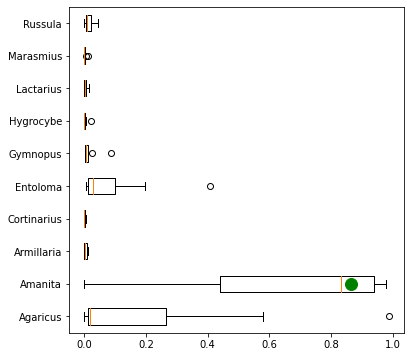

In [13]:
#plot results
plt.figure(figsize=(6,6))
plt.plot(np.max(df_probs), pred[0] + 1,color='green', marker='o' , markersize=12)
plt.boxplot(results.drop(["Ensemble model"], axis=1), labels=results.index , vert=False);

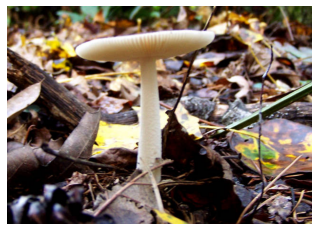

In [14]:
#Display mushroom
img= io.imread(img_path)
plt.imshow(img)
plt.axis("off")
plt.show;